In [61]:
!pip install pmdarima
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings;warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [62]:
saf = pd.read_csv("/kaggle/input/nairobi-stocks-exchange-sharesstocks-data/NSE_SCOM_Safaricom.csv")
saf.head()

,Date,Open,High,Low,Close,Vol.,Change %
0,11-06-2012,3.40,3.45,3.35,3.40,3.24M,0.00%
1,12-06-2012,3.40,3.50,3.40,3.45,6.09M,1.47%
2,13-06-2012,3.45,3.45,3.35,3.40,7.29M,-1.45%
3,14-06-2012,3.40,3.45,3.35,3.40,31.81M,0.00%
4,15-06-2012,3.40,3.50,3.40,3.40,7.57M,0.00%


##### Variable Definitions
      Date: of the stock values, there is one line per day per stock
      High: highest value for the day per stock
      Low: lowest value for the day per stock
      Open: opening value for the day per stock
      Close: closing value for the day per stock
      Volume: number of transactions on that date per stock
       Adj Close: or adjusted close, “is the closing price after adjustments for all applicable splits and dividend distributions”
        Daily Return %: day over day growth of Adj Close

In [63]:
saf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753 entries, 0 to 1752
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1753 non-null   object 
 1   Open      1753 non-null   float64
 2   High      1753 non-null   float64
 3   Low       1753 non-null   float64
 4   Close     1753 non-null   float64
 5   Vol.      1753 non-null   object 
 6   Change %  1753 non-null   object 
dtypes: float64(4), object(3)
memory usage: 96.0+ KB


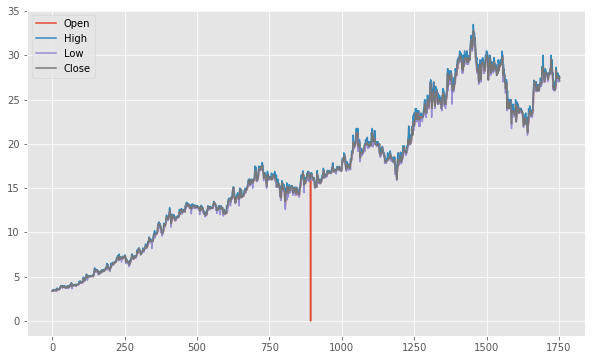

In [64]:
plt.style.use("ggplot")
#plt.figure(figsize = (16,9))
saf.plot(figsize = (10,6));

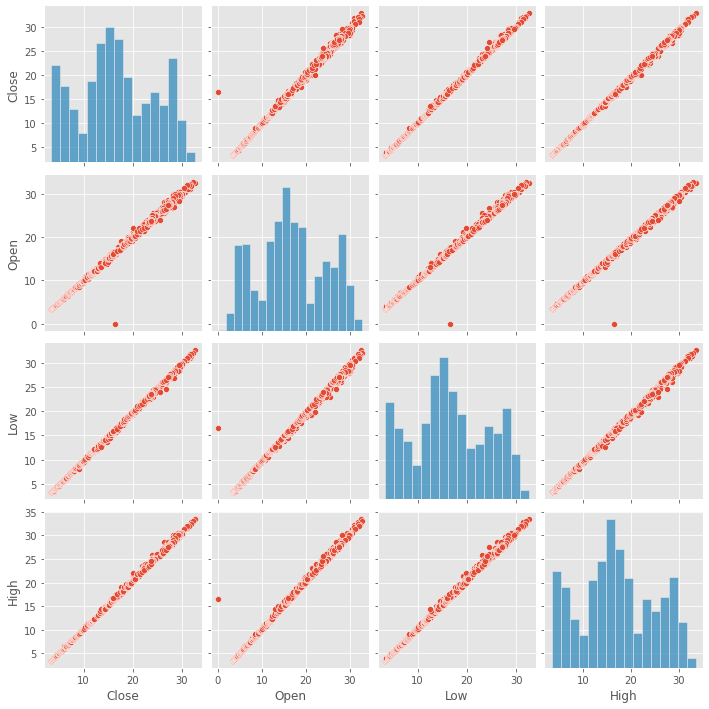

In [65]:
# We will plot a Pairplot of the numerical features
list_num = ["Close", "Open", "Low", "High", "Vol."]
sns.pairplot(saf[list_num]);

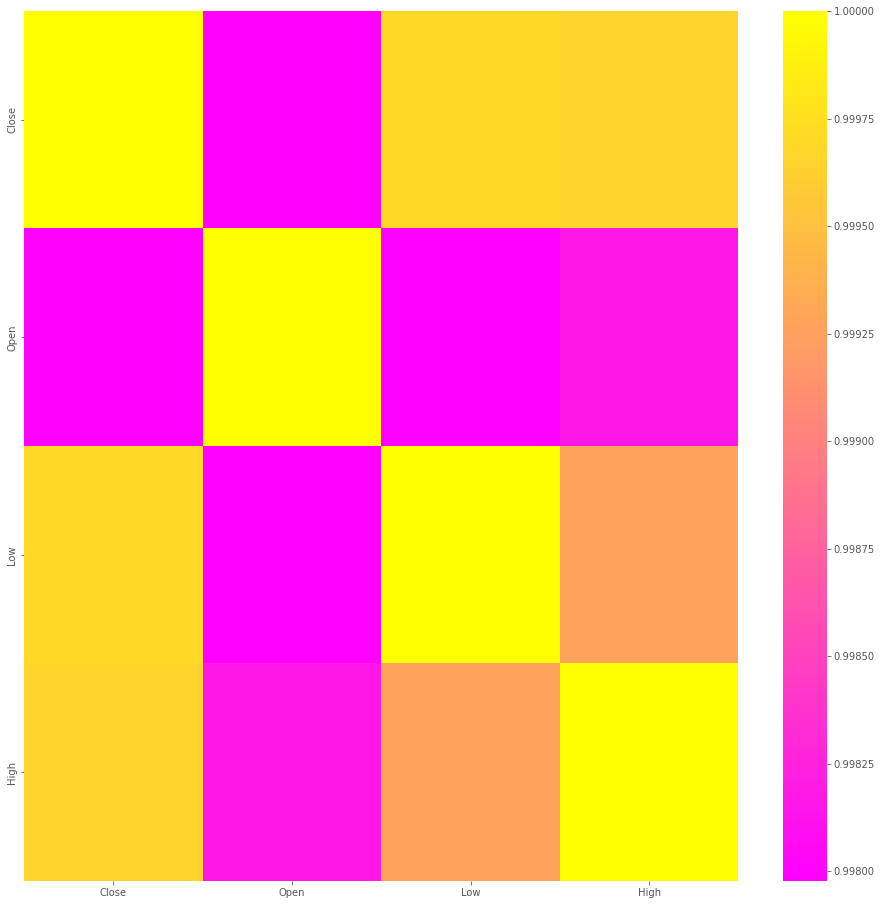

In [66]:
corr = saf[list_num].corr()
f,ag=plt.subplots(figsize=(16,16))
sns.heatmap(corr, cmap="spring");

<Figure size 720x432 with 0 Axes>

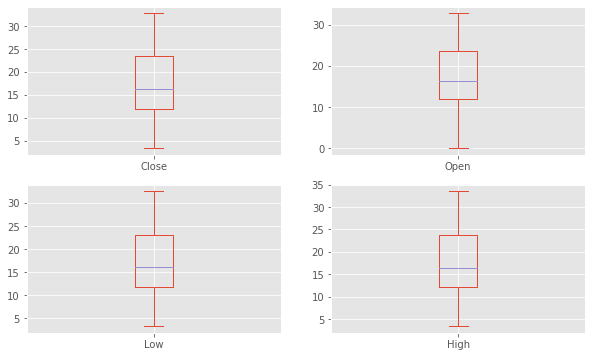

In [67]:
fig = plt.figure()
saf[list_num].plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show();

## Close v Date

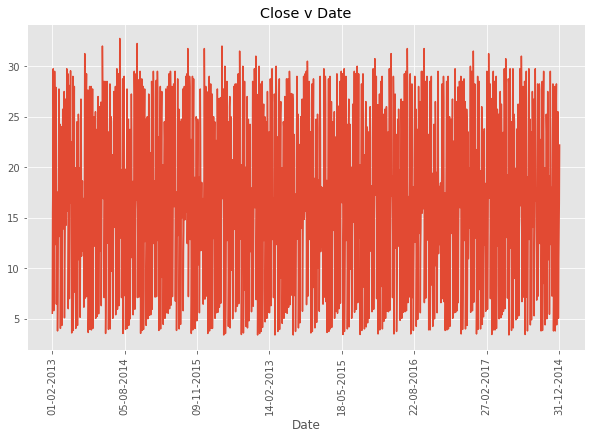

In [68]:
saf.groupby("Date")["Close"].mean().plot()
plt.title("Close v Date")
plt.xticks(rotation = "vertical");

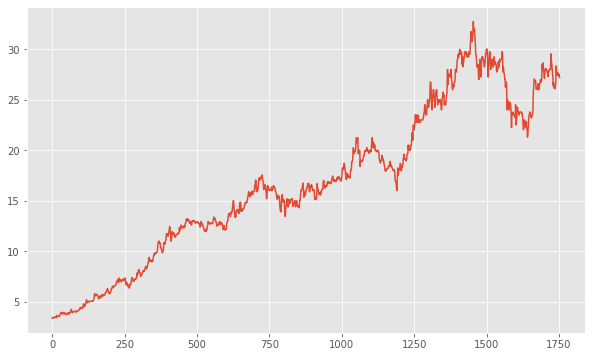

In [69]:
saf['Close'].plot(figsize = (10,6));

## Open v Date

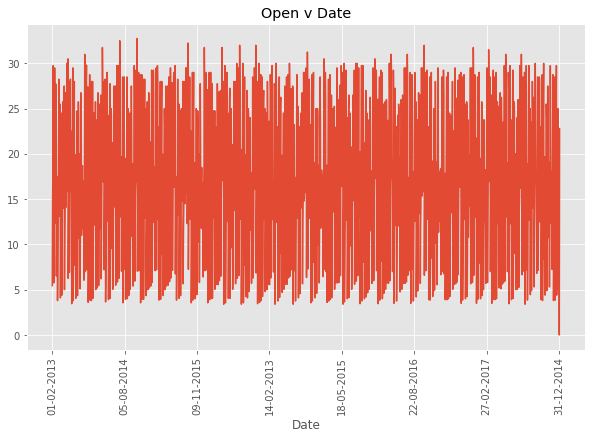

In [70]:
saf.groupby("Date")["Open"].mean().plot()
plt.title("Open v Date")
plt.xticks(rotation = "vertical");

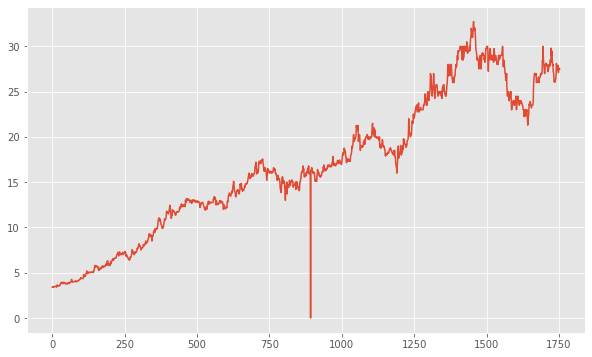

In [71]:
saf['Open'].plot();

## High v Date

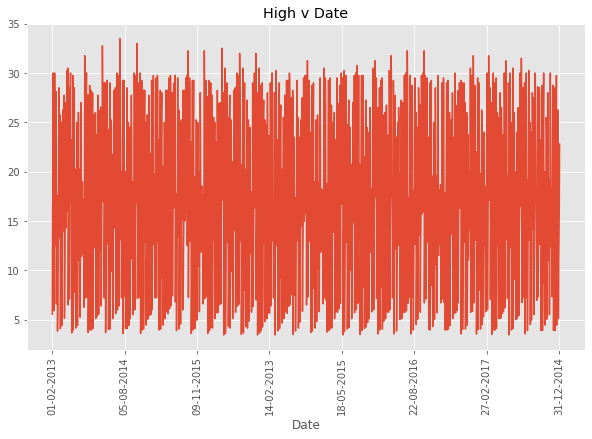

In [72]:
saf.groupby("Date")["High"].mean().plot()
plt.title("High v Date")
plt.xticks(rotation = "vertical");

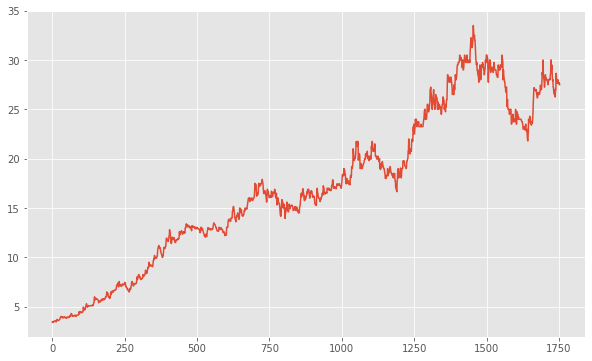

In [73]:
saf['High'].plot().plot(figsize=(16,7));

## Low v Date

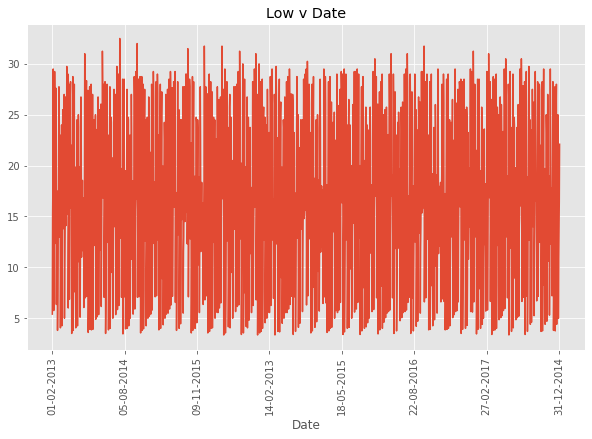

In [74]:
saf.groupby("Date")["Low"].mean().plot()
plt.title("Low v Date")
plt.xticks(rotation = "vertical");

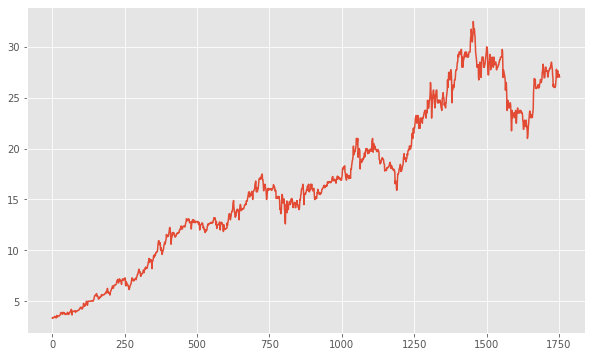

In [75]:
saf['Low'].plot(figsize = (10,6));

## Volume

In [76]:
# Define function to extract the number value from the string
def func(s):
    return eval(s.replace("K", "").replace('M', ""))

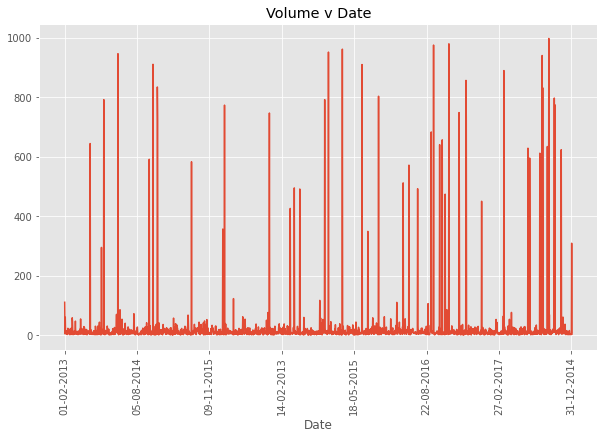

In [77]:
saf["Vol."] = saf["Vol."].apply(func).astype(float)

saf.groupby("Date")["Vol."].mean().plot()
plt.title("Volume v Date")
plt.xticks(rotation = "vertical");

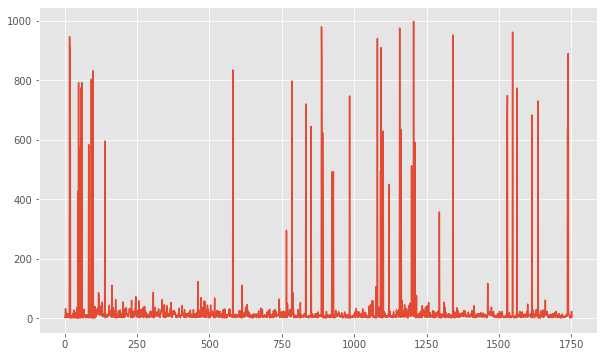

In [78]:
saf['Vol.'].plot();

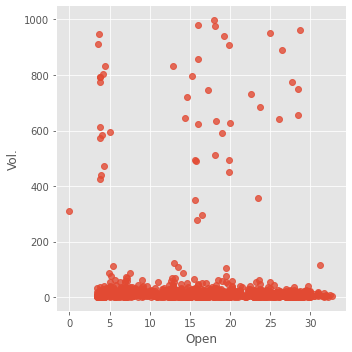

In [79]:
sns.lmplot(x='Open', y='Vol.', data=saf, fit_reg=False);

### OHLC Chart
* an OHLC (open/high/low/close) chart to get a sense of historical prices. 

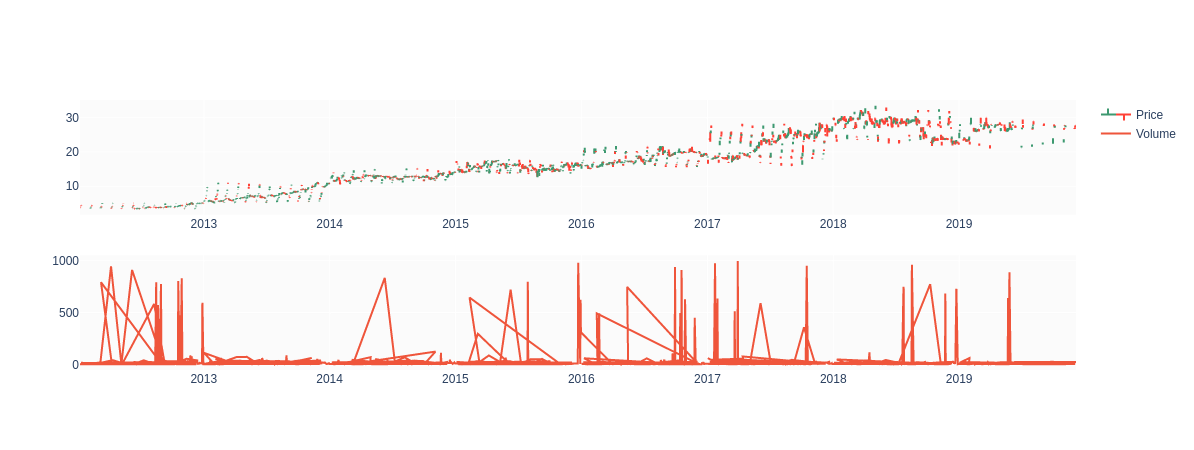

In [80]:
saf["Date"] = pd.to_datetime(saf["Date"])

fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=saf["Date"],
                      open=saf.Open,
                      high=saf.High,
                      low=saf.Low,
                      close=saf.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=saf.Date, y=saf["Vol."], name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

## Time Series Analysis

In [81]:
saff = saf.copy()
saff["Date"] = pd.to_datetime(saff["Date"])
saff = saff.groupby("Date")['Open', 'Close', 'Low', 'High', 'Vol.'].sum()

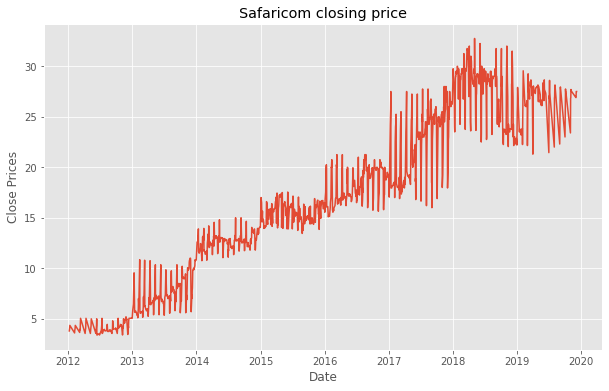

In [82]:
# Visualize the stock's daily closing price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(saff['Close'])
plt.title('Safaricom closing price')
plt.show()

#### ADF (Augmented Dickey-Fuller) Test

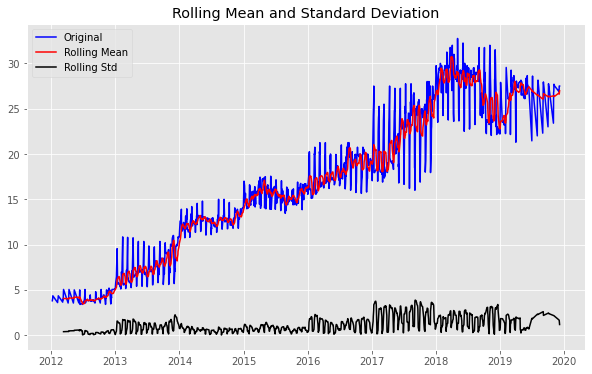

Results of dickey fuller test
Test Statistics                  -1.096420
p-value                           0.716498
No. of lags used                 23.000000
Number of observations used    1729.000000
critical value (1%)              -3.434138
critical value (5%)              -2.863213
critical value (10%)             -2.567661
dtype: float64


In [83]:
close_df = saff['Close']

# Test for staionarity

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(close_df)

<Figure size 720x432 with 0 Axes>

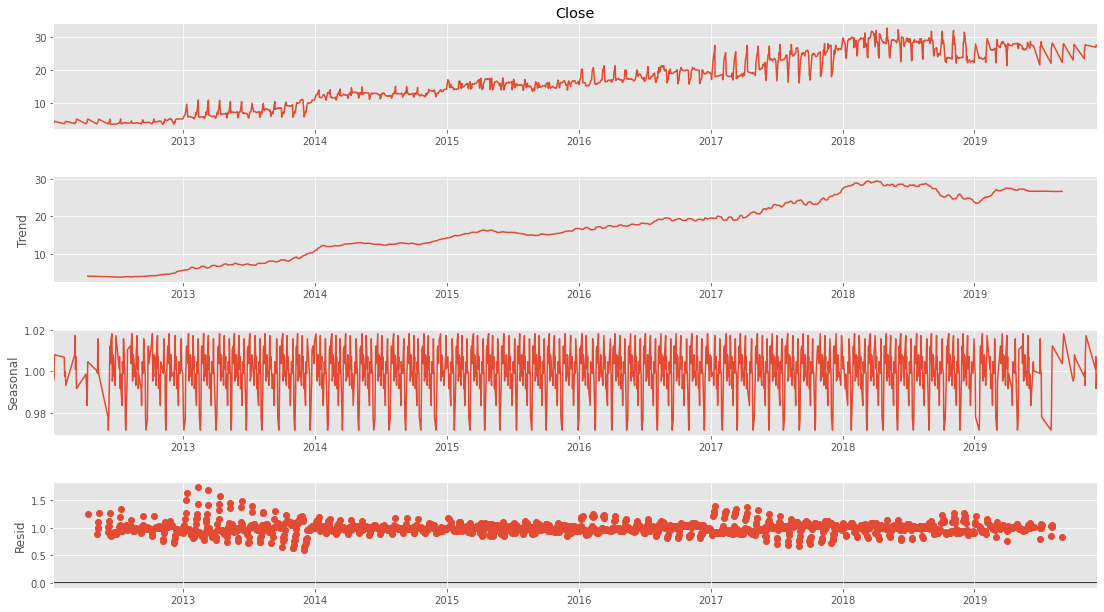

In [84]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(close_df, model='multiplicative', period = 30)
fig = plt.figure();  
fig = result.plot(); 
fig.set_size_inches(16, 9);

#### Technical Indicators

       * Moving averages
* To reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. We then calculate the rolling average of the series after obtaining the log of the series. A _rolling average_ is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

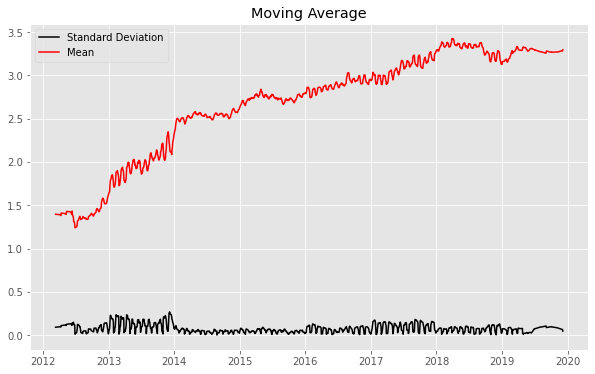

In [85]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(close_df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

    * Moving Averages(2)

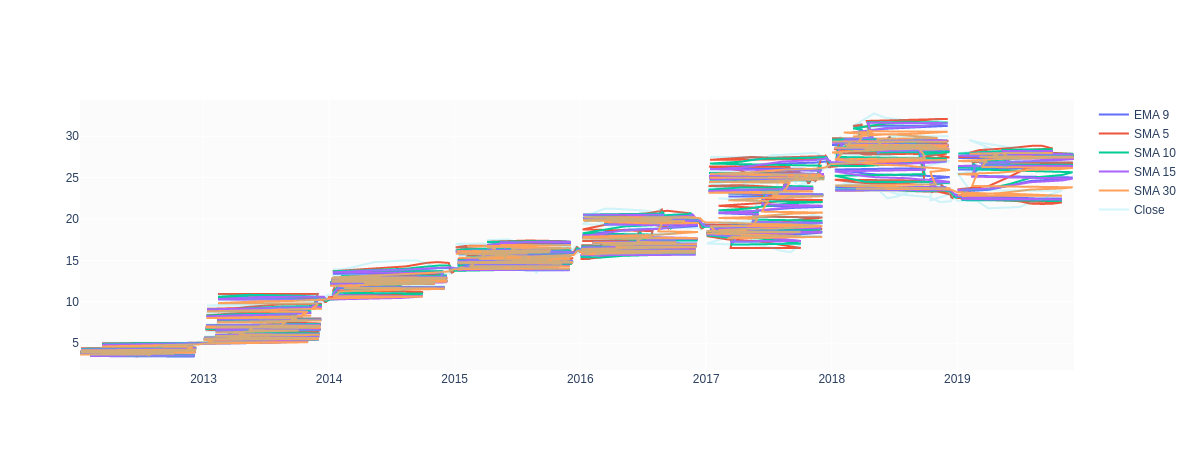

In [86]:
saf['EMA_9'] = saf['Close'].ewm(9).mean().shift()
saf['SMA_5'] = saf['Close'].rolling(5).mean().shift()
saf['SMA_10'] = saf['Close'].rolling(10).mean().shift()
saf['SMA_15'] = saf['Close'].rolling(15).mean().shift()
saf['SMA_30'] = saf['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=saf.Date, y=saf.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=saf.Date, y=saf.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=saf.Date, y=saf.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=saf.Date, y=saf.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=saf.Date, y=saf.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=saf.Date, y=saf.Close, name='Close', opacity=0.2))
fig.show()

### [Pivot it by date](https://www.statology.org/pandas-group-by-month/)

In [87]:
saf["year"] = saf.Date.dt.year
saf["month"] = saf.Date.dt.month_name()

saf

,Date,Open,High,Low,Close,Vol.,Change %,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,year,month
0,2012-11-06,3.40,3.45,3.35,3.40,3.24,0.00%,NaN,NaN,NaN,NaN,NaN,2012,November
1,2012-12-06,3.40,3.50,3.40,3.45,6.09,1.47%,3.400000,NaN,NaN,NaN,NaN,2012,December
2,2012-06-13,3.45,3.45,3.35,3.40,7.29,-1.45%,3.426316,NaN,NaN,NaN,NaN,2012,June
3,2012-06-14,3.40,3.45,3.35,3.40,31.81,0.00%,3.416605,NaN,NaN,NaN,NaN,2012,June
4,2012-06-15,3.40,3.50,3.40,3.40,7.57,0.00%,3.411777,NaN,NaN,NaN,NaN,2012,June
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1748,2019-10-06,27.10,27.60,27.05,27.45,1.33,0.18%,27.369311,27.58,27.515,27.073333,27.476667,2019,October
1749,2019-11-06,27.50,27.70,27.20,27.55,1.71,0.36%,27.377380,27.58,27.615,27.160000,27.460000,2019,November
1750,2019-12-06,27.60,27.65,27.30,27.50,22.67,-0.18%,27.394642,27.56,27.690,27.250000,27.446667,2019,December
1751,2019-06-13,27.50,27.70,27.10,27.35,22.56,-0.55%,27.405178,27.52,27.605,27.326667,27.430000,2019,June


In [88]:
saf_by_year = saf.groupby(["year","month"])['Open', 'Close', 'Low', 'High', 'Vol.', 'month'].sum()
saf_by_year

Open   Close     Low    High     Vol.
year month                                             
2012 April       16.65   16.55   16.35   16.85  1000.04
     August      65.60   65.65   64.90   67.15  4226.01
     December    75.65   75.80   75.25   76.65   782.05
     February    15.65   15.85   15.60   16.15    26.67
     January     12.30   12.20   12.10   12.35    19.16
...                ...     ...     ...     ...      ...
2019 March      468.65  467.95  460.65  474.20   159.22
     May        483.75  483.20  477.55  490.00  1714.85
     November   132.15  132.35  130.85  133.20    24.18
     October    105.30  105.65  104.30  107.50    39.89
     September   78.50   78.10   77.55   79.05    37.08

[96 rows x 5 columns]

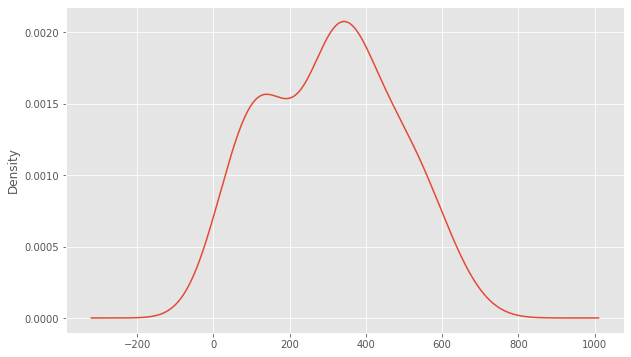

In [89]:
#Distribution of the dataset
df_close = saf_by_year['Close']
df_close.plot(kind='kde');

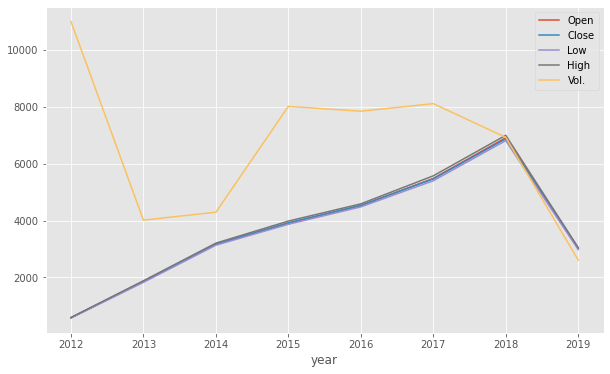

In [90]:
saf.groupby(saf.year)['Open', 'Close', 'Low', 'High', 'Vol.'].sum().plot(figsize = (10,6));

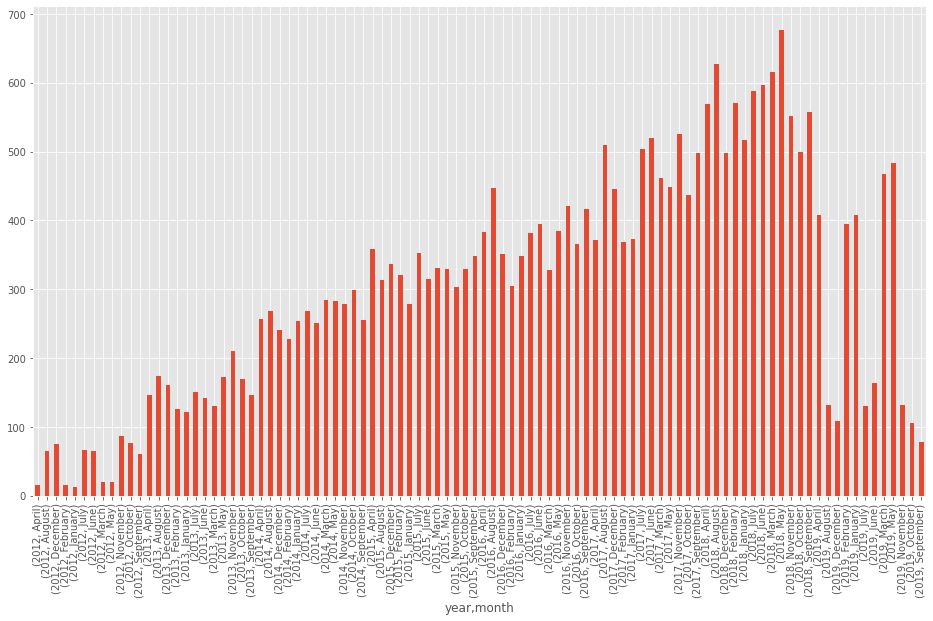

In [91]:
plt.figure(figsize=(16,9))
saf_by_year['Close'].astype(int).plot.bar();

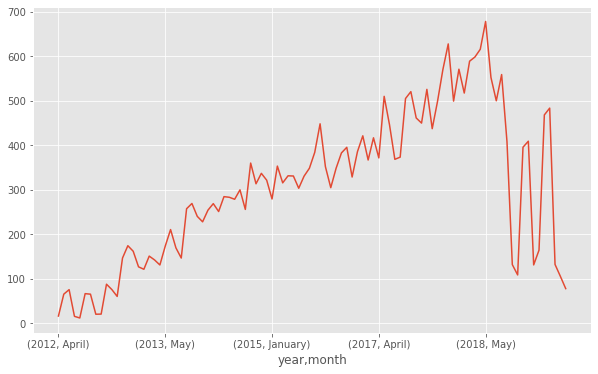

In [92]:
saf_by_year['Close'].plot(figsize = (10,6));

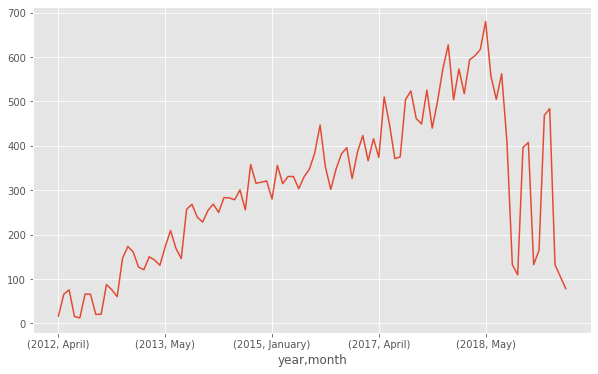

In [93]:
saf_by_year['Open'].plot(figsize = (10,6));

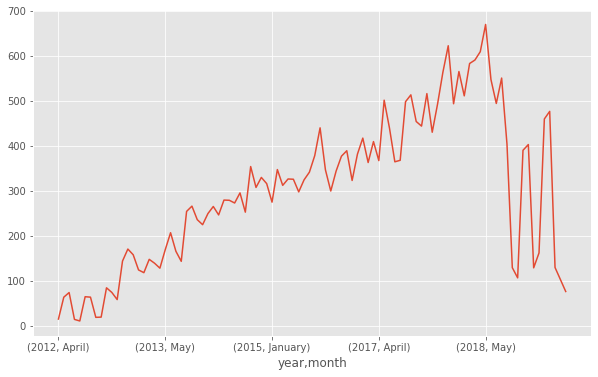

In [94]:
saf_by_year['Low'].plot(figsize = (10,6));

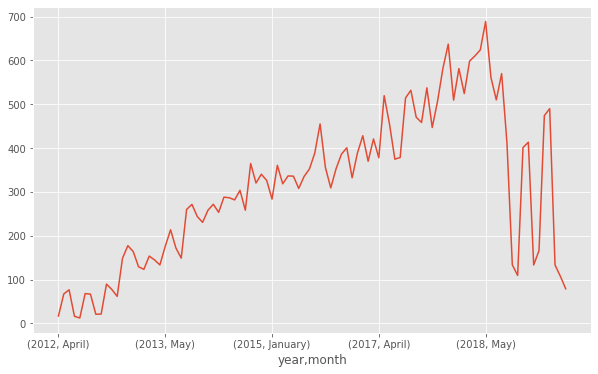

In [95]:
saf_by_year['High'].plot(figsize = (10,6));

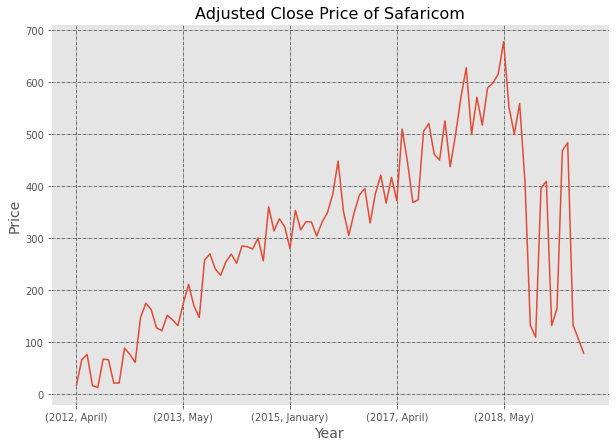

In [96]:
# Plot the adjusted close price
saf_by_year['Close'].plot(figsize=(10, 7))

ticker = "Safaricom"

# Define the label for the title of the figure
plt.title("Adjusted Close Price of %s" % ticker, fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

# Show the plot
plt.show()

* Clearly, Safaricom shares seem to have peaked in 2018. I will study 2012 and 2015 for clear undsertanding. 

<Figure size 720x432 with 0 Axes>

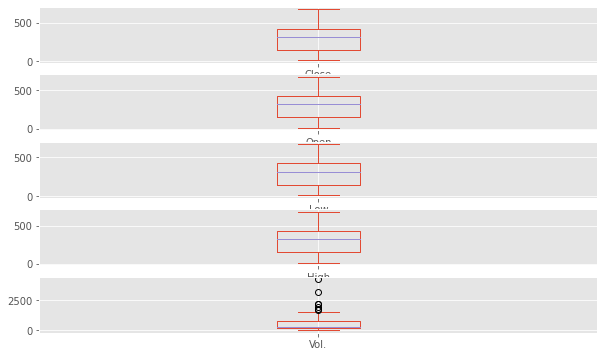

In [97]:
fig = plt.figure()
saf_by_year[list_num].plot(kind='box', subplots=True, layout=(5,1), sharex=False, sharey=False)
plt.show();

### The year 2012
* There was some terrorism activities in the country

In [98]:
saf_2012 = saf_by_year.query("year == 2012")
saf_2012

Open  Close    Low   High     Vol.
year month                                         
2012 April      16.65  16.55  16.35  16.85  1000.04
     August     65.60  65.65  64.90  67.15  4226.01
     December   75.65  75.80  75.25  76.65   782.05
     February   15.65  15.85  15.60  16.15    26.67
     January    12.30  12.20  12.10  12.35    19.16
     July       66.40  66.80  65.95  68.00   184.74
     June       65.70  65.61  65.00  66.70  1056.45
     March      20.30  20.60  20.15  20.80   850.09
     May        20.90  20.90  20.65  21.30    24.17
     November   87.55  87.95  85.75  89.65   493.94
     October    75.75  76.00  75.45  77.40  2187.10
     September  60.25  60.55  59.60  61.60   149.17

In [99]:
saf_2012 = saf.groupby("month")['Open', 'Close', 'Low', 'High', 'Vol.'].sum()

saf_2012

,Open,Close,Low,High,Vol.
month,,,,,
April,2517.45,2513.80,2488.85,2549.70,2727.55
August,2539.45,2539.35,2509.40,2582.15,6859.08
December,2206.95,2220.10,2192.50,2254.40,5750.12
February,2333.60,2331.05,2307.35,2368.75,3297.41
January,2315.70,2314.40,2287.65,2347.30,3329.68
July,2452.80,2446.80,2420.35,2486.35,3973.12
June,2460.20,2452.26,2425.20,2492.70,4990.17
March,2639.10,2640.40,2607.30,2679.75,4212.13
May,2805.70,2804.15,2773.40,2846.35,4167.91


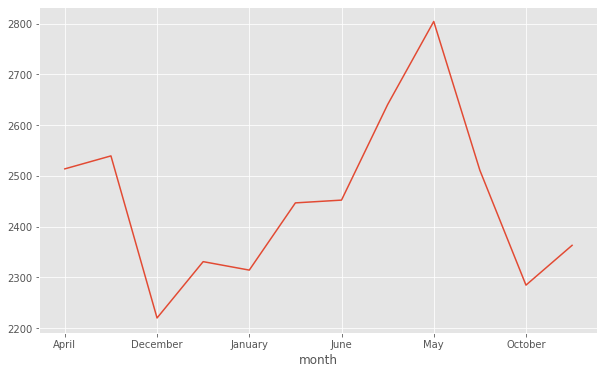

In [100]:
saf_2012["Close"].plot(figsize = (10,6));

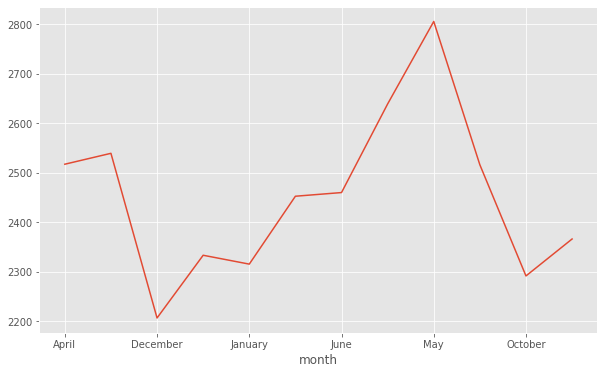

In [101]:
saf_2012["Open"].plot(figsize = (10,6));

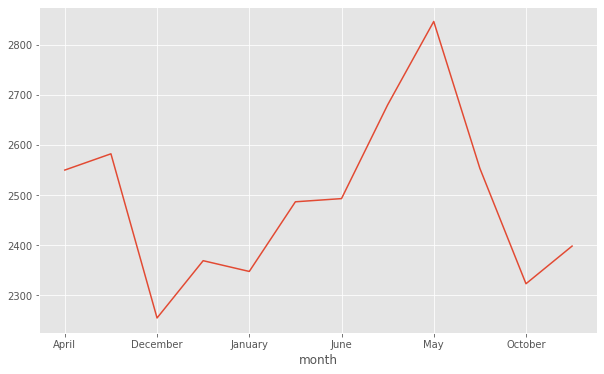

In [102]:
saf_2012["High"].plot(figsize = (10,6));

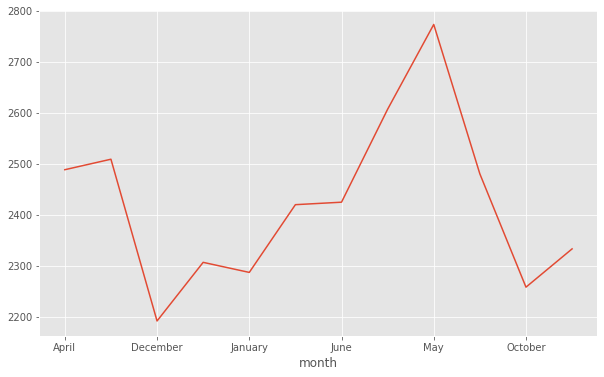

In [103]:
saf_2012["Low"].plot(figsize = (10,6));

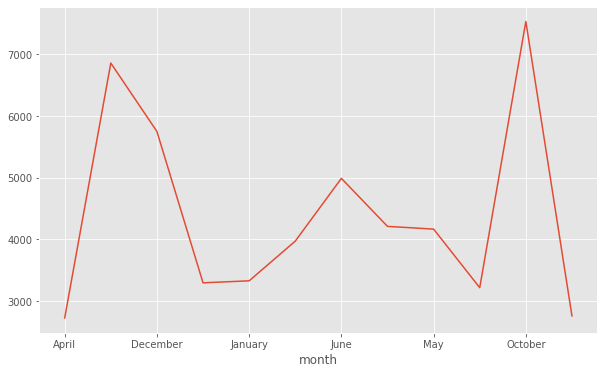

In [104]:
saf_2012["Vol."].plot(figsize = (10,6));

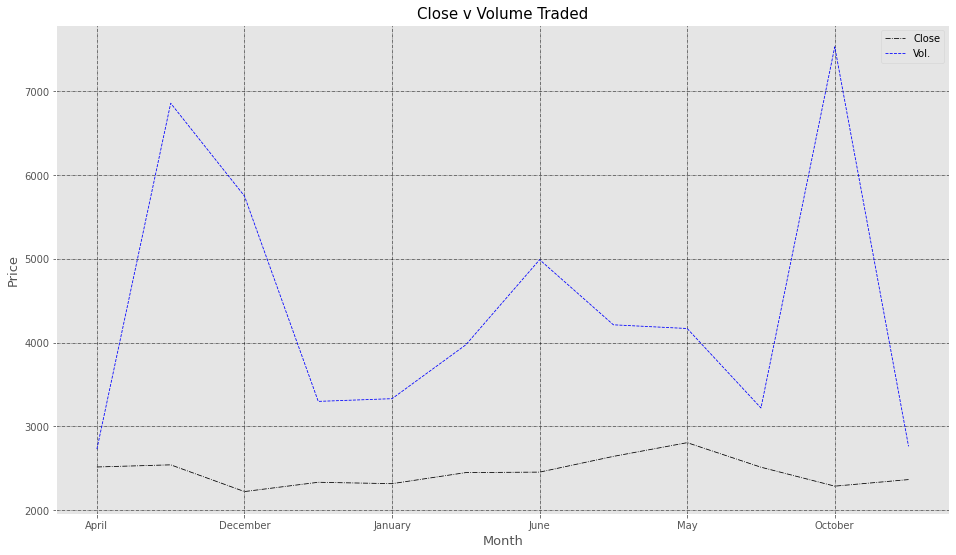

In [105]:
plt.figure(figsize=(16,9))
saf_2012["Close"].plot(color='k', linestyle='-.', linewidth=0.8)
saf_2012["Vol."].plot(color='b', linestyle='--', linewidth=0.8)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.title("Close v Volume Traded", fontsize = 15)
plt.xlabel("Month",fontsize=13)
plt.ylabel("Price", fontsize=13)
plt.legend();

## Prediction
* Using LSTM

[Credits](https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm)

In [106]:
# Create a new dataframe with only the 'Close column 
data = saf.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

1666

In [107]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.        ],
       [0.00170358],
       [0.        ],
       ...,
       [0.82112436],
       [0.81601363],
       [0.8109029 ]])

In [108]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.        , 0.00170358, 0.        , 0.        , 0.        ,
       0.00170358, 0.00170358, 0.00340716, 0.00340716, 0.00340716,
       0.00340716, 0.00340716, 0.00170358, 0.        , 0.00170358,
       0.00681431, 0.00851789, 0.00511073, 0.00511073, 0.00545145,
       0.00511073, 0.00511073, 0.00511073, 0.00681431, 0.00511073,
       0.00681431, 0.00851789, 0.01192504, 0.0153322 , 0.01703578,
       0.01703578, 0.0153322 , 0.01873935, 0.01873935, 0.01703578,
       0.01362862, 0.01362862, 0.01362862, 0.0153322 , 0.01873935,
       0.0153322 , 0.0153322 , 0.0153322 , 0.01703578, 0.01362862,
       0.01192504, 0.01192504, 0.01192504, 0.01192504, 0.01192504,
       0.01192504, 0.0153322 , 0.01703578, 0.01703578, 0.01703578,
       0.0153322 , 0.01362862, 0.0153322 , 0.01362862, 0.01703578])]
[0.018739352640545145]

[array([0.        , 0.00170358, 0.        , 0.        , 0.        ,
       0.00170358, 0.00170358, 0.00340716, 0.00340716, 0.00340716,
       0.00340716, 0.00340716, 0.0

In [109]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1606/1606 [==============================] - 71s 42ms/step - loss: 0.0014


In [110]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

1.2146637746702633

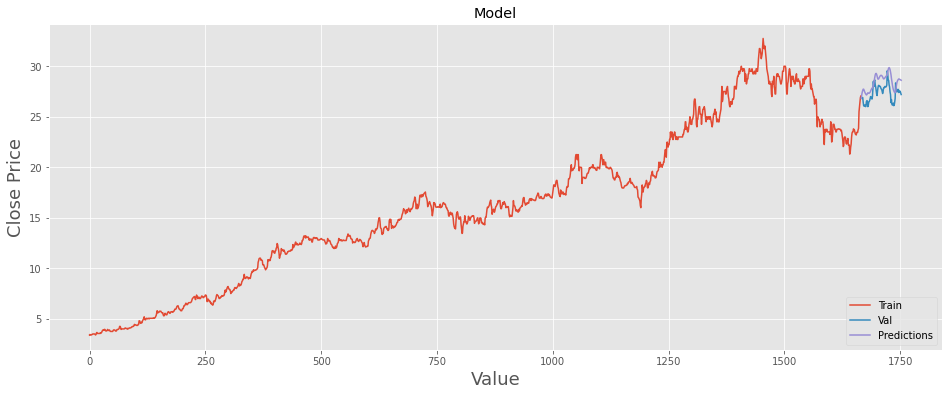

In [111]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Value', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [112]:
# Show the valid and predicted prices
valid

,Close,Predictions
1666,26.85,26.834898
1667,26.80,27.200970
1668,26.90,27.445690
1669,26.90,27.616951
1670,26.45,27.729790
...,...,...
1748,27.45,28.726339
1749,27.55,28.691061
1750,27.50,28.671101
1751,27.35,28.652222


* ARIMA Model

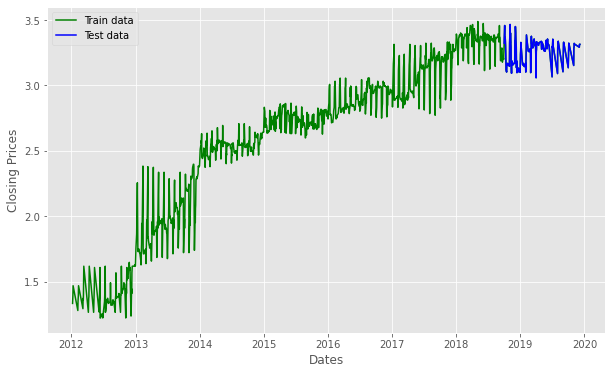

In [113]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3335.376, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3355.936, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3362.309, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3337.042, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3394.897, Time=1.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3547.906, Time=3.85 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3548.659, Time=7.70 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3507.442, Time=3.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.52 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-3541.022, Time=1.77 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 27.836 seconds
                               SARIMAX Results                                
Dep. Variable:

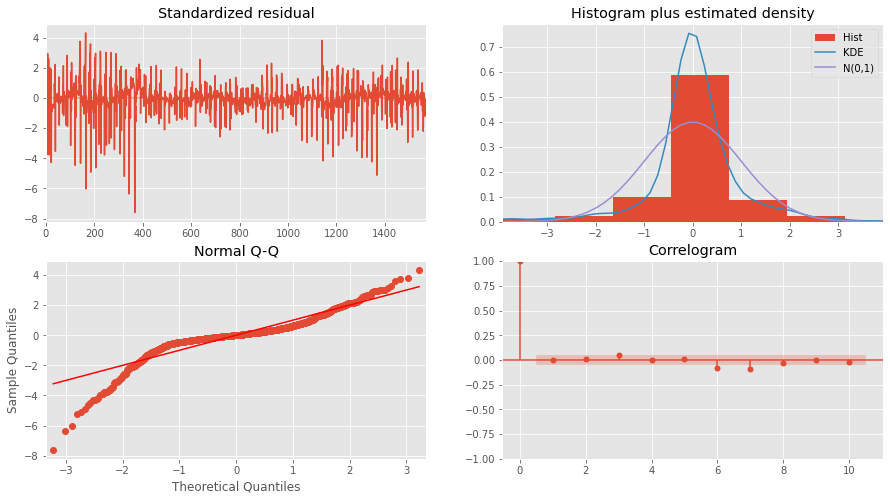

In [114]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [115]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1574
Model:                 ARIMA(1, 1, 2)   Log Likelihood                1771.443
Date:                Tue, 06 Dec 2022   AIC                          -3534.887
Time:                        23:07:45   BIC                          -3513.444
Sample:                             0   HQIC                         -3526.918
                               - 1574                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6258      0.037     16.852      0.000       0.553       0.699
ma.L1         -0.8724      0.049    -17.748      0.000      -0.969      -0.776
ma.L2         -0.0627      0.041     -1.537      0.1

* XGBoost

In [116]:
# Split the data into training and testing sets
#train = saf[:int(len(saf) * 0.8)]
#test = saf[int(len(saf) * 0.8):]


In [117]:
saf.drop(["year", "Date", "Change %", "month"], inplace =True, axis =1)
# Splitting the dataset into 70% training, 15% validation and 15% test
# train test split indexes
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(saf.shape[0] * (1-test_size))
valid_split_idx = int(saf.shape[0] * (1-(valid_size+test_size)))  


#train test split tcs
train= saf.loc[:valid_split_idx]
valid= saf.loc[valid_split_idx+1:test_split_idx]
test= saf.loc[test_split_idx+1:]

#fig = go.Figure()
#fig.add_trace(go.Scatter(x=train.Date, y=train.Close, name='Training'))
#fig.add_trace(go.Scatter(x=valid.Date, y=valid.Close, name='Validation'))
#fig.add_trace(go.Scatter(x=test.Date,  y=test.Close,  name='Test'))
#fig.show()

In [118]:
# Create XGBoost data matrices for training and testing
#dtrain = xgb.DMatrix(train[['Open', 'High', 'Low', 'Vol.']], label=train['label'])
#dtest = xgb.DMatrix(test[['Clo']], label=test['label'])

In [119]:
y_train = train['Close']
X_train = train.drop(['Close'], 1)

y_valid = valid['Close']
X_valid = valid.drop(['Close'], 1)

y_test = test['Close']
X_test = test.drop(['Close'], 1)

In [120]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV,KFold

parameters = {
    'n_estimators': [500,600],
    'learning_rate': [0.1],
    'max_depth': [8, 12, 15],
    'gamma': [ 0.005, 0.01,],
    'random_state': [42],
    'min_child_weight':[4,3],
    'subsample':[0.8,1],
    'colsample_bytree':[1],
    'colsample_bylevel':[1]
}
kfold=KFold(5)
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = XGBRegressor(objective='reg:squarederror',n_jobs=-1)
clf = GridSearchCV(model, parameters,cv=kfold,scoring='neg_mean_absolute_error',verbose=0)
clf.fit(X_train, y_train)


print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.005, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 3, 'n_estimators': 500, 'random_state': 42, 'subsample': 1}
Best validation score = -0.7354306419819411


In [121]:
model = XGBRegressor(**clf.best_params_, objective='reg:squarederror',n_jobs=-1)
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
y_pred=model.predict(X_test)
mean_absolute_error(y_test,y_pred)

5.5186161157739075

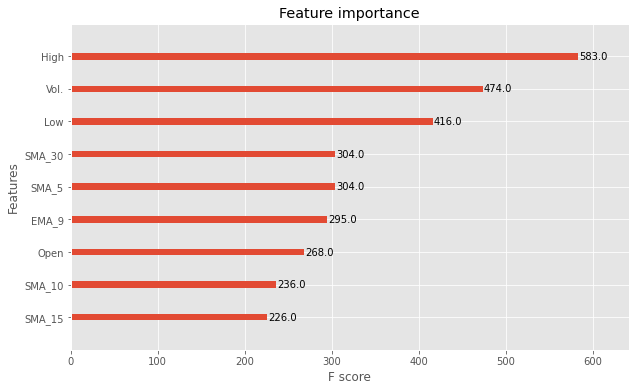

In [122]:
xgb.plot_importance(model);saf.drop(["year", "Change %", "month"], inplace =True, axis =1)

######### Handtuning the hyperparameters

In [123]:
params={'colsample_bylevel': 1,
 'colsample_bytree': 0.6,
 'gamma': 0.005,
 'learning_rate': 0.07,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 170,
 'random_state': 42,
 'subsample': 0.6}
eval_set = [(X_train, y_train), (X_valid, y_valid)]
xgb=XGBRegressor(**params, objective='reg:squarederror',n_jobs=-1)
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)
y_pred = xgb.predict(X_test)
mean_absolute_error(y_test, y_pred)

5.797389343494677

In [124]:
#plt.figure(figsize=(15,8))
#sns.lineplot(y=y_pred,x=np.arange())
#sns.lineplot(y=y_test,x=np.arange(0))
#plt.legend(['Y-Predicted','Y-True'])
#plt.title('Y-True vs Y-Predicted')
#plt.show();

#### References
* https://www.analyticsvidhya.com/blog/2021/07/stock-market-forecasting-using-time-series-analysis-with-arima-model/
* https://www.kaggle.com/code/vaibhavsoni09/stock-market-prediction-using-xgboost/notebook
* https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm
* https://www.kaggle.com/code/jagannathrk/stock-market-time-series
* https://www.kaggle.com/code/mtszkw/xgboost-for-stock-trend-prices-prediction
* ChatGPT